In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
from torchsummary import summary

#vital params

 
model_name="ResNet50_stn2"

dataset_name="caltech101"

#hyperparameters
batch_size=10
num_classes=-1
learning_rate=0.001
input_size=784
image_size=(224,224)


if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10
elif dataset_name == "caltech101":
    num_classes=101
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)


# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
elif dataset_name == "caltech101":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    train_dir = "../../dataset/caltech101"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [7477, 1200])
    train_set, test_set = data.random_split(train_set,[6277, 1200])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
    
    
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)




print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))

print(head_train_set.class_to_idx)
print(train_set[0][0].shape)
print("Datasets loaded and prepared")


Model: ResNet50_stn2 with 101 classes running on: caltech101
Dataset size: Train: 6277, Valid: 1200, Test: 1200
{'Faces': 0, 'Faces_easy': 1, 'Leopards': 2, 'Motorbikes': 3, 'accordion': 4, 'airplanes': 5, 'anchor': 6, 'ant': 7, 'barrel': 8, 'bass': 9, 'beaver': 10, 'binocular': 11, 'bonsai': 12, 'brain': 13, 'brontosaurus': 14, 'buddha': 15, 'butterfly': 16, 'camera': 17, 'cannon': 18, 'car_side': 19, 'ceiling_fan': 20, 'cellphone': 21, 'chair': 22, 'chandelier': 23, 'cougar_body': 24, 'cougar_face': 25, 'crab': 26, 'crayfish': 27, 'crocodile': 28, 'crocodile_head': 29, 'cup': 30, 'dalmatian': 31, 'dollar_bill': 32, 'dolphin': 33, 'dragonfly': 34, 'electric_guitar': 35, 'elephant': 36, 'emu': 37, 'euphonium': 38, 'ewer': 39, 'ferry': 40, 'flamingo': 41, 'flamingo_head': 42, 'garfield': 43, 'gerenuk': 44, 'gramophone': 45, 'grand_piano': 46, 'hawksbill': 47, 'headphone': 48, 'hedgehog': 49, 'helicopter': 50, 'ibis': 51, 'inline_skate': 52, 'joshua_tree': 53, 'kangaroo': 54, 'ketch': 55

In [2]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

        self.localization = nn.Sequential(
            nn.Conv2d(3,4,kernel_size=3,stride = 2,padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,10,kernel_size=1),
            nn.BatchNorm2d(10),
            nn.ReLU(True),

        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(27040, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        


        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

        
    # Spatial transformer network forward function
    def stn(self, x):

        xs = self.localization(x)

        xs = xs.view(-1, 10 * 52 * 52)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
                
    def forward(self, x):
        self.stn(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)



def ResNet50(img_channel=3, num_classes=num_classes):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=num_classes):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=num_classes):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)


def test():
    net = ResNet101(img_channel=3, num_classes=num_classes)
    y = net(torch.randn(4, 3, 224, 224)).to(device)
    print(y.size())


test()

C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


torch.Size([4, 101])


In [3]:
model=ResNet50(img_channel=3, num_classes=num_classes).to(device)

#pretesting model for shape
x=torch.randn(batch_size,3,224,224)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print("model shape ready")
print(summary(model, input_size=(3, 224, 224)))
#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
print("model initialised")

torch.Size([10, 3, 224, 224])
torch.Size([10, 101])
model shape ready
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 112, 112]             112
       BatchNorm2d-2          [-1, 4, 112, 112]               8
              ReLU-3          [-1, 4, 112, 112]               0
            Conv2d-4          [-1, 8, 112, 112]              40
       BatchNorm2d-5          [-1, 8, 112, 112]              16
              ReLU-6          [-1, 8, 112, 112]               0
            Conv2d-7          [-1, 8, 110, 110]             584
       BatchNorm2d-8          [-1, 8, 110, 110]              16
              ReLU-9          [-1, 8, 110, 110]               0
           Conv2d-10          [-1, 4, 110, 110]              36
      BatchNorm2d-11          [-1, 4, 110, 110]               8
             ReLU-12          [-1, 4, 110, 110]               0
           Conv2d-13          [-1

In [4]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.3f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.3f}%)'.format(
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
    return 100.000 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

test defined
early stop defined


In [5]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+"/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs//ResNet50_stn220211228201041
grandstore_string
grandstore/caltech101_ResNet50_stn220211228201041.pkl


In [6]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.3f}'.format(training_accuracy))
        print('Training Loss: {:.4f} \tValidation Loss: {:.4f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore
        


In [7]:
TOP_ACCURACY_TRACK = 15
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=400,
                    minepoch=300,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.25                 
                   )

Running epoch: 1


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 20.917
Training Loss: 8587223.3776 	Validation Loss: 4515.7027

Running epoch: 2


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 25.333
Training Loss: 7603398.3458 	Validation Loss: 4247.1986

Running epoch: 3


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 27.750
Training Loss: 6891542.1357 	Validation Loss: 3831.6501

Running epoch: 4


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 32.417
Training Loss: 6473938.9707 	Validation Loss: 3958.1611

Running epoch: 5


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 37.333
Training Loss: 5980933.8530 	Validation Loss: 3462.7506

Running epoch: 6


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 41.417
Training Loss: 5556658.8088 	Validation Loss: 3248.6371

Running epoch: 7


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 45.500
Training Loss: 5181383.4619 	Validation Loss: 2936.1343

Running epoch: 8


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 47.750
Training Loss: 4545780.8576 	Validation Loss: 2753.3344

Running epoch: 9


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 53.750
Training Loss: 4050321.4573 	Validation Loss: 2368.7673

Running epoch: 10


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 56.917
Training Loss: 3557727.2856 	Validation Loss: 2454.5918

Running epoch: 11


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 57.333
Training Loss: 3115522.7567 	Validation Loss: 2310.8164

Running epoch: 12


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.500
Training Loss: 2815503.8509 	Validation Loss: 1981.6363

Running epoch: 13


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.667
Training Loss: 2462422.2734 	Validation Loss: 1882.8348

Running epoch: 14


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.250
Training Loss: 2183342.5531 	Validation Loss: 1856.1277

Running epoch: 15


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.083
Training Loss: 1809073.2613 	Validation Loss: 1804.2638

Running epoch: 16


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.083
Training Loss: 1506958.5459 	Validation Loss: 1784.0393

Running epoch: 17


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.250
Training Loss: 1317629.2905 	Validation Loss: 1830.4588

Running epoch: 18


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.667
Training Loss: 1047716.2037 	Validation Loss: 1779.8173

Running epoch: 19


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 829098.3215 	Validation Loss: 1866.2449

Running epoch: 20


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.417
Training Loss: 698380.1675 	Validation Loss: 1822.2024

Running epoch: 21


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.750
Training Loss: 567223.3439 	Validation Loss: 1885.1786

Running epoch: 22


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.667
Training Loss: 463160.8117 	Validation Loss: 1861.3773

Running epoch: 23


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.333
Training Loss: 379802.3405 	Validation Loss: 2014.9646

Running epoch: 24


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.667
Training Loss: 332186.0068 	Validation Loss: 2157.4020

Running epoch: 25


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.917
Training Loss: 330458.6596 	Validation Loss: 1878.8884

Running epoch: 26


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.083
Training Loss: 263070.2203 	Validation Loss: 1994.5369

Running epoch: 27


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.000
Training Loss: 247607.3992 	Validation Loss: 2363.8603

Running epoch: 28


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.083
Training Loss: 301849.2234 	Validation Loss: 1976.2415

Running epoch: 29


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.917
Training Loss: 183653.3536 	Validation Loss: 2309.3805

Running epoch: 30


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.000
Training Loss: 187056.2639 	Validation Loss: 2065.3231

Running epoch: 31


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.250
Training Loss: 179032.3175 	Validation Loss: 2156.5569

Running epoch: 32


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.250
Training Loss: 194359.4030 	Validation Loss: 2056.0346

Running epoch: 33


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.500
Training Loss: 185624.3919 	Validation Loss: 2123.7243

Running epoch: 34


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 169735.4263 	Validation Loss: 2035.6343

Running epoch: 35


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.000
Training Loss: 142736.9793 	Validation Loss: 1997.5288

Running epoch: 36


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.083
Training Loss: 127126.3302 	Validation Loss: 2175.0902

Running epoch: 37


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.167
Training Loss: 122518.4287 	Validation Loss: 2108.0981

Running epoch: 38


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.500
Training Loss: 100089.8492 	Validation Loss: 2013.5481

Running epoch: 39


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.750
Training Loss: 94548.7507 	Validation Loss: 2171.6111

Running epoch: 40


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.583
Training Loss: 166110.8459 	Validation Loss: 2079.3112

Running epoch: 41


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.833
Training Loss: 52541.0500 	Validation Loss: 2173.3108

Running epoch: 42


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.583
Training Loss: 130538.6562 	Validation Loss: 2162.4064

Running epoch: 43


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.500
Training Loss: 90549.5785 	Validation Loss: 2179.5351

Running epoch: 44


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.250
Training Loss: 70805.5782 	Validation Loss: 2436.3429

Running epoch: 45


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.500
Training Loss: 122844.4723 	Validation Loss: 2093.3644

Running epoch: 46


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.417
Training Loss: 77404.1100 	Validation Loss: 2011.1714

Running epoch: 47


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.083
Training Loss: 95494.3430 	Validation Loss: 2145.6423

Running epoch: 48


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 48551.9294 	Validation Loss: 2267.8581

Running epoch: 49


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.167
Training Loss: 79273.4591 	Validation Loss: 2165.4076

Running epoch: 50


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 112957.5142 	Validation Loss: 2145.0347

Running epoch: 51


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.500
Training Loss: 73956.8788 	Validation Loss: 2060.9882

Running epoch: 52


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.083
Training Loss: 72902.5552 	Validation Loss: 2035.1922

Running epoch: 53


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.000
Training Loss: 51579.0946 	Validation Loss: 2029.8906

Running epoch: 54


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.333
Training Loss: 54296.1235 	Validation Loss: 2183.1120

Running epoch: 55


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.167
Training Loss: 55370.4391 	Validation Loss: 2169.5235

Running epoch: 56


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.417
Training Loss: 62000.4901 	Validation Loss: 2183.5011

Running epoch: 57


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.917
Training Loss: 130107.8336 	Validation Loss: 2092.2021

Running epoch: 58


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 58780.8627 	Validation Loss: 2116.3298

Running epoch: 59


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.500
Training Loss: 37950.0371 	Validation Loss: 1961.6580

Running epoch: 60


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.583
Training Loss: 63492.1600 	Validation Loss: 2205.1747

Running epoch: 61


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.083
Training Loss: 53471.0759 	Validation Loss: 2207.7722

Running epoch: 62


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.417
Training Loss: 45362.6328 	Validation Loss: 2380.7306

Running epoch: 63


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 65328.2228 	Validation Loss: 2290.3807

Running epoch: 64


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.333
Training Loss: 46768.4258 	Validation Loss: 2300.3003

Running epoch: 65


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.917
Training Loss: 63748.5545 	Validation Loss: 2184.6421

Running epoch: 66


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.583
Training Loss: 33476.6727 	Validation Loss: 2299.0970

Running epoch: 67


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.750
Training Loss: 48988.6248 	Validation Loss: 2103.8223

Running epoch: 68


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 61106.7800 	Validation Loss: 2373.8130

Running epoch: 69


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.500
Training Loss: 61252.8958 	Validation Loss: 2249.4383

Running epoch: 70


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.500
Training Loss: 25466.5742 	Validation Loss: 2348.3385

Running epoch: 71


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.667
Training Loss: 27444.0594 	Validation Loss: 2430.2623

Running epoch: 72


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.833
Training Loss: 70690.1247 	Validation Loss: 2239.2121

Running epoch: 73


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 36419.6940 	Validation Loss: 2184.0986

Running epoch: 74


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.500
Training Loss: 26882.2083 	Validation Loss: 2235.4971

Running epoch: 75


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.000
Training Loss: 82172.8559 	Validation Loss: 2226.3807

Running epoch: 76


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.667
Training Loss: 28143.5774 	Validation Loss: 2233.0697

Running epoch: 77


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.667
Training Loss: 18262.6151 	Validation Loss: 2196.7115

Running epoch: 78


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 31975.1890 	Validation Loss: 2458.4278

Running epoch: 79


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.583
Training Loss: 71471.2700 	Validation Loss: 2367.9379

Running epoch: 80


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.833
Training Loss: 32000.4861 	Validation Loss: 2095.1413

Running epoch: 81


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.833
Training Loss: 34890.3715 	Validation Loss: 2071.8064

Running epoch: 82


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.500
Training Loss: 6356.5282 	Validation Loss: 2318.2223

Running epoch: 83


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.750
Training Loss: 20408.4371 	Validation Loss: 2655.8763

Running epoch: 84


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.417
Training Loss: 76382.9764 	Validation Loss: 3777.6441

Running epoch: 85


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.333
Training Loss: 17233.0557 	Validation Loss: 2312.8201

Running epoch: 86


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.333
Training Loss: 40361.7985 	Validation Loss: 2324.1079

Running epoch: 87


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 14471.1720 	Validation Loss: 2453.7570

Running epoch: 88


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.500
Training Loss: 64224.5742 	Validation Loss: 2505.4802

Running epoch: 89


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.250
Training Loss: 41338.6495 	Validation Loss: 2212.8171

Running epoch: 90


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.667
Training Loss: 16755.9307 	Validation Loss: 2322.5791

Running epoch: 91


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.500
Training Loss: 27966.0078 	Validation Loss: 2297.5410

Running epoch: 92


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 41487.9242 	Validation Loss: 2250.7767

Running epoch: 93


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.833
Training Loss: 22233.5607 	Validation Loss: 2210.3823

Running epoch: 94


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.750
Training Loss: 6832.1112 	Validation Loss: 2092.5871

Running epoch: 95


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.500
Training Loss: 15449.9423 	Validation Loss: 2375.4042

Running epoch: 96


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.917
Training Loss: 56462.2550 	Validation Loss: 2172.0965

Running epoch: 97


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.833
Training Loss: 21416.9807 	Validation Loss: 2322.2940

Running epoch: 98


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.333
Training Loss: 25435.2086 	Validation Loss: 2166.2707

Running epoch: 99


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 20367.8890 	Validation Loss: 2174.9780

Running epoch: 100


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.167
Training Loss: 42416.1624 	Validation Loss: 2358.4159

Running epoch: 101


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.417
Training Loss: 36043.1250 	Validation Loss: 2150.7350

Running epoch: 102


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.500
Training Loss: 29934.6245 	Validation Loss: 2171.0129

Running epoch: 103


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.167
Training Loss: 13209.7943 	Validation Loss: 2062.4035

Running epoch: 104


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.083
Training Loss: 29404.8681 	Validation Loss: 2171.6032

Running epoch: 105


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.000
Training Loss: 59233.4467 	Validation Loss: 2176.1773

Running epoch: 106


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.083
Training Loss: 13352.4193 	Validation Loss: 1994.4236

Running epoch: 107


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.417
Training Loss: 14925.0119 	Validation Loss: 2294.3982

Running epoch: 108


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.333
Training Loss: 14817.2867 	Validation Loss: 2548.7912

Running epoch: 109


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.333
Training Loss: 32746.8336 	Validation Loss: 2612.6566

Running epoch: 110


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 42879.1096 	Validation Loss: 2185.7978

Running epoch: 111


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.917
Training Loss: 35405.9502 	Validation Loss: 2517.2283

Running epoch: 112


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.583
Training Loss: 10997.5779 	Validation Loss: 2139.6441

Running epoch: 113


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 3117.6971 	Validation Loss: 2189.2926

Running epoch: 114


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.667
Training Loss: 1383.1210 	Validation Loss: 2478.1223

Running epoch: 115


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.250
Training Loss: 61044.0884 	Validation Loss: 2362.4896

Running epoch: 116


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.667
Training Loss: 18380.4753 	Validation Loss: 2157.6387

Running epoch: 117


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.167
Training Loss: 11112.3661 	Validation Loss: 2203.2210

Running epoch: 118


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.833
Training Loss: 44769.8872 	Validation Loss: 2301.6612

Running epoch: 119


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.833
Training Loss: 21799.2336 	Validation Loss: 2128.8285

Running epoch: 120


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.250
Training Loss: 7342.3421 	Validation Loss: 2269.5767

Running epoch: 121


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.167
Training Loss: 29251.2249 	Validation Loss: 2043.1354

Running epoch: 122


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.750
Training Loss: 19138.1898 	Validation Loss: 2346.5468

Running epoch: 123


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.917
Training Loss: 11581.5544 	Validation Loss: 2311.9363

Running epoch: 124


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 23938.7382 	Validation Loss: 2310.9731

Running epoch: 125


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 16772.8158 	Validation Loss: 2141.8804

Running epoch: 126


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.833
Training Loss: 15716.9268 	Validation Loss: 2356.1313

Running epoch: 127


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.167
Training Loss: 21464.1324 	Validation Loss: 2225.7732

Running epoch: 128


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.833
Training Loss: 4417.9851 	Validation Loss: 2224.9064

Running epoch: 129


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.917
Training Loss: 5104.5841 	Validation Loss: 2718.5301

Running epoch: 130


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.250
Training Loss: 60099.4417 	Validation Loss: 2271.8074

Running epoch: 131


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.667
Training Loss: 14147.6958 	Validation Loss: 2173.2014

Running epoch: 132


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.250
Training Loss: 10920.5628 	Validation Loss: 2441.0521

Running epoch: 133


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.750
Training Loss: 36988.1674 	Validation Loss: 2171.9766

Running epoch: 134


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.750
Training Loss: 11151.9443 	Validation Loss: 2284.3134

Running epoch: 135


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.833
Training Loss: 20981.2420 	Validation Loss: 2356.5562

Running epoch: 136


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.250
Training Loss: 14928.9365 	Validation Loss: 2309.4816

Running epoch: 137


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.083
Training Loss: 18555.8967 	Validation Loss: 2109.8733

Running epoch: 138


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 10836.5272 	Validation Loss: 2625.3767

Running epoch: 139


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.583
Training Loss: 50457.7949 	Validation Loss: 2267.9348

Running epoch: 140


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.083
Training Loss: 17230.2930 	Validation Loss: 2182.2079

Running epoch: 141


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.583
Training Loss: 2934.4513 	Validation Loss: 2051.0473

Running epoch: 142


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.833
Training Loss: 4187.8511 	Validation Loss: 2093.0108

Running epoch: 143


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 382.9311 	Validation Loss: 2031.2442

Running epoch: 144


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.917
Training Loss: 39358.8445 	Validation Loss: 2258.8260

Running epoch: 145


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.750
Training Loss: 30420.9204 	Validation Loss: 2173.1078

Running epoch: 146


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.417
Training Loss: 14379.9035 	Validation Loss: 2181.7247

Running epoch: 147


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.250
Training Loss: 8659.9605 	Validation Loss: 1997.6050

Running epoch: 148


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.500
Training Loss: 7371.8871 	Validation Loss: 2194.9618

Running epoch: 149


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.333
Training Loss: 18981.5131 	Validation Loss: 2261.1372

Running epoch: 150


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 12456.5520 	Validation Loss: 2626.4457

Running epoch: 151


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.667
Training Loss: 46517.1311 	Validation Loss: 2106.9361

Running epoch: 152


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.833
Training Loss: 4861.3692 	Validation Loss: 2151.4350

Running epoch: 153


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.167
Training Loss: 1058.5171 	Validation Loss: 2173.6133

Running epoch: 154


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.833
Training Loss: 12582.9224 	Validation Loss: 2489.8257

Running epoch: 155


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.500
Training Loss: 12721.0070 	Validation Loss: 2351.1413

Running epoch: 156


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.667
Training Loss: 16757.5882 	Validation Loss: 2441.2767

Running epoch: 157


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.917
Training Loss: 31061.8705 	Validation Loss: 2369.5962

Running epoch: 158


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.833
Training Loss: 11206.0340 	Validation Loss: 2147.0592

Running epoch: 159


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.333
Training Loss: 3866.8146 	Validation Loss: 2222.3800

Running epoch: 160


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.167
Training Loss: 610.7565 	Validation Loss: 2082.5446

Running epoch: 161


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 189.2983 	Validation Loss: 2156.6342

Running epoch: 162


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.167
Training Loss: 190.1639 	Validation Loss: 2183.9441

Running epoch: 163


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.667
Training Loss: 35523.1797 	Validation Loss: 2443.0950

Running epoch: 164


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.500
Training Loss: 30676.7738 	Validation Loss: 2129.1609

Running epoch: 165


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.167
Training Loss: 2629.4985 	Validation Loss: 2167.5973

Running epoch: 166


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.000
Training Loss: 8959.6240 	Validation Loss: 2194.3740

Running epoch: 167


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.417
Training Loss: 13658.2964 	Validation Loss: 2158.0541

Running epoch: 168


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.083
Training Loss: 3767.8495 	Validation Loss: 2217.2337

Running epoch: 169


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.417
Training Loss: 25507.9395 	Validation Loss: 2401.0084

Running epoch: 170


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.417
Training Loss: 12237.3531 	Validation Loss: 2228.4167

Running epoch: 171


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.250
Training Loss: 16895.1549 	Validation Loss: 2229.2618

Running epoch: 172


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.250
Training Loss: 8467.3387 	Validation Loss: 2363.9036

Running epoch: 173


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.500
Training Loss: 6125.5820 	Validation Loss: 2342.6087

Running epoch: 174


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.333
Training Loss: 23611.2964 	Validation Loss: 2135.3345

Running epoch: 175


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.667
Training Loss: 6431.5984 	Validation Loss: 2217.8270

Running epoch: 176


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 25675.3553 	Validation Loss: 2219.1533

Running epoch: 177


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.333
Training Loss: 10075.4536 	Validation Loss: 2449.5234

Running epoch: 178


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.167
Training Loss: 24311.2623 	Validation Loss: 2309.6713

Running epoch: 179


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.417
Training Loss: 2540.1975 	Validation Loss: 2194.3191

Running epoch: 180


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.750
Training Loss: 2621.0981 	Validation Loss: 2232.8590

Running epoch: 181


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.000
Training Loss: 38872.5364 	Validation Loss: 2217.4266

Running epoch: 182


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.083
Training Loss: 3043.6149 	Validation Loss: 2237.3183

Running epoch: 183


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.083
Training Loss: 5113.0173 	Validation Loss: 2273.1297

Running epoch: 184


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.333
Training Loss: 24354.8601 	Validation Loss: 2433.5332

Running epoch: 185


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 4900.2129 	Validation Loss: 2337.0047

Running epoch: 186


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.500
Training Loss: 1822.7670 	Validation Loss: 2512.2231

Running epoch: 187


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.083
Training Loss: 49208.0456 	Validation Loss: 2378.9412

Running epoch: 188


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.333
Training Loss: 6021.8922 	Validation Loss: 2548.9842

Running epoch: 189


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.083
Training Loss: 21071.1895 	Validation Loss: 2260.0399

Running epoch: 190


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.500
Training Loss: 1062.8561 	Validation Loss: 2144.4635

Running epoch: 191


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.333
Training Loss: 480.4007 	Validation Loss: 2336.5492

Running epoch: 192


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.583
Training Loss: 28424.9853 	Validation Loss: 2499.8091

Running epoch: 193


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.083
Training Loss: 27542.2222 	Validation Loss: 2447.9954

Running epoch: 194


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.750
Training Loss: 9761.1229 	Validation Loss: 2339.0840

Running epoch: 195


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.250
Training Loss: 4384.2945 	Validation Loss: 2299.4451

Running epoch: 196


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 17571.6257 	Validation Loss: 2458.7854

Running epoch: 197


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.500
Training Loss: 12205.8347 	Validation Loss: 2554.6475

Running epoch: 198


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.167
Training Loss: 26506.0152 	Validation Loss: 2274.4771

Running epoch: 199


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.417
Training Loss: 1373.6239 	Validation Loss: 2303.4976

Running epoch: 200


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 2100.8614 	Validation Loss: 2184.0296

Running epoch: 201


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.000
Training Loss: 786.8474 	Validation Loss: 2374.7053

Running epoch: 202


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.750
Training Loss: 57189.9017 	Validation Loss: 2454.7689

Running epoch: 203


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.250
Training Loss: 6677.3423 	Validation Loss: 2403.7325

Running epoch: 204


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 2020.7920 	Validation Loss: 2369.1494

Running epoch: 205


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.500
Training Loss: 4893.7278 	Validation Loss: 2674.2585

Running epoch: 206


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.917
Training Loss: 15844.3195 	Validation Loss: 2395.8387

Running epoch: 207


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.833
Training Loss: 10645.9706 	Validation Loss: 2290.8796

Running epoch: 208


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 3286.8215 	Validation Loss: 2608.5745

Running epoch: 209


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.333
Training Loss: 46697.4166 	Validation Loss: 2423.4498

Running epoch: 210


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.250
Training Loss: 7817.8490 	Validation Loss: 2322.3721

Running epoch: 211


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.167
Training Loss: 4776.0794 	Validation Loss: 2218.6077

Running epoch: 212


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.333
Training Loss: 1348.4265 	Validation Loss: 2495.9140

Running epoch: 213


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.333
Training Loss: 24808.8962 	Validation Loss: 2430.7956

Running epoch: 214


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.417
Training Loss: 10615.3140 	Validation Loss: 2496.4226

Running epoch: 215


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.750
Training Loss: 12076.7631 	Validation Loss: 2517.8816

Running epoch: 216


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 11763.1971 	Validation Loss: 2301.5284

Running epoch: 217


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 4249.0963 	Validation Loss: 2331.4385

Running epoch: 218


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.500
Training Loss: 2001.3335 	Validation Loss: 2304.3093

Running epoch: 219


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 69.583
Training Loss: 2136.9025 	Validation Loss: 2961.1565

Running epoch: 220


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.500
Training Loss: 49654.8148 	Validation Loss: 2198.5048

Running epoch: 221


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.167
Training Loss: 6569.3813 	Validation Loss: 2302.9956

Running epoch: 222


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.417
Training Loss: 1173.1137 	Validation Loss: 2196.5988

Running epoch: 223


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.167
Training Loss: 717.0702 	Validation Loss: 2259.8787

Running epoch: 224


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.750
Training Loss: 300.4323 	Validation Loss: 2317.8750

Running epoch: 225


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.167
Training Loss: 31639.9089 	Validation Loss: 2351.2125

Running epoch: 226


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 10787.5254 	Validation Loss: 2463.3051

Running epoch: 227


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.083
Training Loss: 1223.2661 	Validation Loss: 2352.5180

Running epoch: 228


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.500
Training Loss: 6875.9391 	Validation Loss: 2720.6303

Running epoch: 229


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.083
Training Loss: 24619.0106 	Validation Loss: 2277.2673

Running epoch: 230


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.167
Training Loss: 3510.4372 	Validation Loss: 2265.6050

Running epoch: 231


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.250
Training Loss: 2196.8690 	Validation Loss: 2319.9935

Running epoch: 232


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.500
Training Loss: 12821.0989 	Validation Loss: 2398.4714

Running epoch: 233


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.417
Training Loss: 4271.7570 	Validation Loss: 2918.7660

Running epoch: 234


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.667
Training Loss: 28044.3490 	Validation Loss: 2461.6387

Running epoch: 235


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.500
Training Loss: 2581.9318 	Validation Loss: 2370.0170

Running epoch: 236


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.167
Training Loss: 734.8225 	Validation Loss: 2412.5030

Running epoch: 237


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.917
Training Loss: 27865.1365 	Validation Loss: 2510.4605

Running epoch: 238


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.833
Training Loss: 8320.4692 	Validation Loss: 2518.0960

Running epoch: 239


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.333
Training Loss: 12048.9711 	Validation Loss: 2440.7761

Running epoch: 240


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 19502.1830 	Validation Loss: 2863.1640

Running epoch: 241


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.417
Training Loss: 16127.1304 	Validation Loss: 2411.1930

Running epoch: 242


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.083
Training Loss: 1189.9291 	Validation Loss: 2261.4818

Running epoch: 243


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.583
Training Loss: 368.3237 	Validation Loss: 2232.1943

Running epoch: 244


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.083
Training Loss: 693.6843 	Validation Loss: 2299.0453

Running epoch: 245


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.417
Training Loss: 231.5067 	Validation Loss: 2349.5926

Running epoch: 246


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.250
Training Loss: 46645.8616 	Validation Loss: 2384.2268

Running epoch: 247


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 6246.1378 	Validation Loss: 2358.9821

Running epoch: 248


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.750
Training Loss: 3251.3789 	Validation Loss: 2415.7291

Running epoch: 249


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.250
Training Loss: 3689.1204 	Validation Loss: 2335.9570

Running epoch: 250


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.083
Training Loss: 15790.7059 	Validation Loss: 2475.3393

Running epoch: 251


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 71.500
Training Loss: 3822.9633 	Validation Loss: 3152.7709

Running epoch: 252


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.333
Training Loss: 36891.2059 	Validation Loss: 2456.2992

Running epoch: 253


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 9376.3922 	Validation Loss: 2369.4816

Running epoch: 254


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.333
Training Loss: 3682.6324 	Validation Loss: 2513.3878

Running epoch: 255


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.250
Training Loss: 12629.6694 	Validation Loss: 2352.1297

Running epoch: 256


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.083
Training Loss: 7382.6967 	Validation Loss: 2598.4856

Running epoch: 257


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.083
Training Loss: 15569.8623 	Validation Loss: 2325.3182

Running epoch: 258


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.583
Training Loss: 10813.1071 	Validation Loss: 2474.8265

Running epoch: 259


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.750
Training Loss: 5397.1700 	Validation Loss: 2355.2710

Running epoch: 260


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.333
Training Loss: 1080.3118 	Validation Loss: 2243.0401

Running epoch: 261


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.750
Training Loss: 190.6484 	Validation Loss: 2176.1011

Running epoch: 262


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.417
Training Loss: 176.3117 	Validation Loss: 2104.1217

Running epoch: 263


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.333
Training Loss: 1052.2619 	Validation Loss: 2332.8082

Running epoch: 264


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.000
Training Loss: 46168.6904 	Validation Loss: 2821.5508

Running epoch: 265


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.750
Training Loss: 11204.9764 	Validation Loss: 2531.6624

Running epoch: 266


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.083
Training Loss: 4566.6816 	Validation Loss: 2463.5568

Running epoch: 267


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.167
Training Loss: 6377.3338 	Validation Loss: 2568.3301

Running epoch: 268


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.917
Training Loss: 1652.2631 	Validation Loss: 2561.1384

Running epoch: 269


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.833
Training Loss: 17061.8903 	Validation Loss: 2529.4551

Running epoch: 270


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.333
Training Loss: 21203.0360 	Validation Loss: 2301.9810

Running epoch: 271


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.250
Training Loss: 1257.7502 	Validation Loss: 2294.4823

Running epoch: 272


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.083
Training Loss: 1446.5558 	Validation Loss: 2239.8678

Running epoch: 273


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 70.000
Training Loss: 3163.1760 	Validation Loss: 3196.1712

Running epoch: 274


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.250
Training Loss: 23311.2813 	Validation Loss: 2582.8540

Running epoch: 275


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.000
Training Loss: 4359.6882 	Validation Loss: 2388.8529

Running epoch: 276


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.833
Training Loss: 1228.5414 	Validation Loss: 2530.4395

Running epoch: 277


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.083
Training Loss: 11821.9755 	Validation Loss: 2269.0688

Running epoch: 278


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.333
Training Loss: 12333.0936 	Validation Loss: 2392.3547

Running epoch: 279


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.333
Training Loss: 1808.1283 	Validation Loss: 2248.2137

Running epoch: 280


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.833
Training Loss: 1596.1664 	Validation Loss: 2360.2078

Running epoch: 281


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.583
Training Loss: 15962.7550 	Validation Loss: 2811.9116

Running epoch: 282


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.833
Training Loss: 14585.6108 	Validation Loss: 2683.9900

Running epoch: 283


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.000
Training Loss: 6897.5746 	Validation Loss: 2563.7644

Running epoch: 284


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 3105.1334 	Validation Loss: 2426.7650

Running epoch: 285


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.250
Training Loss: 17755.3412 	Validation Loss: 2518.7097

Running epoch: 286


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.167
Training Loss: 11715.2456 	Validation Loss: 2297.9792

Running epoch: 287


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.917
Training Loss: 882.9976 	Validation Loss: 2397.0334

Running epoch: 288


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.917
Training Loss: 317.1850 	Validation Loss: 2312.1685

Running epoch: 289


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.083
Training Loss: 12925.4222 	Validation Loss: 2730.6030

Running epoch: 290


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.250
Training Loss: 11597.3012 	Validation Loss: 2507.4936

Running epoch: 291


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.917
Training Loss: 3940.5104 	Validation Loss: 2475.0382

Running epoch: 292


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.083
Training Loss: 19632.4870 	Validation Loss: 2824.5047

Running epoch: 293


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.000
Training Loss: 24738.7035 	Validation Loss: 2491.6237

Running epoch: 294


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.583
Training Loss: 7191.5088 	Validation Loss: 2509.8133

Running epoch: 295


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.667
Training Loss: 818.0022 	Validation Loss: 2602.1937

Running epoch: 296


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 5393.2319 	Validation Loss: 2560.3195

Running epoch: 297


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.583
Training Loss: 3029.1262 	Validation Loss: 2576.4703

Running epoch: 298


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.083
Training Loss: 24067.8727 	Validation Loss: 2607.4730

Running epoch: 299


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.750
Training Loss: 21169.2968 	Validation Loss: 2432.8473

Running epoch: 300


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.417
Training Loss: 4886.2837 	Validation Loss: 2605.7947

Running epoch: 301


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.917
Training Loss: 4361.9503 	Validation Loss: 2523.9498

Running epoch: 302


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.750
Training Loss: 4843.3289 	Validation Loss: 2689.3191

Running epoch: 303


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.667
Training Loss: 9799.0089 	Validation Loss: 2703.2351

Running epoch: 304


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.583
Training Loss: 4951.6900 	Validation Loss: 2377.6928

Running epoch: 305


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.750
Training Loss: 2322.9010 	Validation Loss: 2236.7618

Running epoch: 306


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.750
Training Loss: 327.3487 	Validation Loss: 2391.8112

Running epoch: 307


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.417
Training Loss: 120.0864 	Validation Loss: 2337.0454

Running epoch: 308


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.583
Training Loss: 430.5792 	Validation Loss: 2385.3047

Running epoch: 309


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.750
Training Loss: 797.3323 	Validation Loss: 2466.0577

Running epoch: 310


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.833
Training Loss: 45703.1959 	Validation Loss: 2749.0112

Running epoch: 311


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.000
Training Loss: 2775.9913 	Validation Loss: 2454.2992

Running epoch: 312


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.500
Training Loss: 12732.3226 	Validation Loss: 2432.2064

Running epoch: 313


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.500
Training Loss: 3287.1789 	Validation Loss: 2583.2626

Running epoch: 314


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.583
Training Loss: 19799.4922 	Validation Loss: 2707.3134

Running epoch: 315


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 11606.9791 	Validation Loss: 2316.0072

Running epoch: 316


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.500
Training Loss: 537.5622 	Validation Loss: 2484.4961

Running epoch: 317


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.833
Training Loss: 4485.3313 	Validation Loss: 2344.6248

Running epoch: 318


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.750
Training Loss: 426.0033 	Validation Loss: 2243.6310

Running epoch: 319


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.833
Training Loss: 200.2139 	Validation Loss: 2352.0221

Running epoch: 320


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.333
Training Loss: 1250.1144 	Validation Loss: 2861.6399

Running epoch: 321


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.750
Training Loss: 23225.6033 	Validation Loss: 2714.7863

Running epoch: 322


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.167
Training Loss: 10542.5246 	Validation Loss: 2475.1770

Running epoch: 323


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.417
Training Loss: 2777.4012 	Validation Loss: 2541.3993

Running epoch: 324


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.333
Training Loss: 200.7224 	Validation Loss: 2452.0064

Running epoch: 325


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.667
Training Loss: 21578.7141 	Validation Loss: 2607.0335

Running epoch: 326


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.583
Training Loss: 11353.3316 	Validation Loss: 2379.5170

Running epoch: 327


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.917
Training Loss: 5216.1234 	Validation Loss: 2497.6391

Running epoch: 328


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.083
Training Loss: 8607.9833 	Validation Loss: 2318.3841

Running epoch: 329


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.250
Training Loss: 2283.4314 	Validation Loss: 2382.8728

Running epoch: 330


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.000
Training Loss: 262.6308 	Validation Loss: 2360.1418

Running epoch: 331


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.083
Training Loss: 5355.7221 	Validation Loss: 2827.6221

Running epoch: 332


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.917
Training Loss: 17249.6830 	Validation Loss: 2514.8838

Running epoch: 333


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.833
Training Loss: 12645.0103 	Validation Loss: 2711.7119

Running epoch: 334


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.417
Training Loss: 1847.6313 	Validation Loss: 2479.3139

Running epoch: 335


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.083
Training Loss: 280.3426 	Validation Loss: 2397.2725

Running epoch: 336


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 1867.3224 	Validation Loss: 2557.7547

Running epoch: 337


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.583
Training Loss: 197.3479 	Validation Loss: 2464.7860

Running epoch: 338


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.833
Training Loss: 129.6818 	Validation Loss: 2593.6414

Running epoch: 339


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.000
Training Loss: 30727.2802 	Validation Loss: 2694.2757

Running epoch: 340


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.000
Training Loss: 3185.7549 	Validation Loss: 2755.0090

Running epoch: 341


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.083
Training Loss: 10341.7320 	Validation Loss: 2567.2785

Running epoch: 342


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.667
Training Loss: 8021.1720 	Validation Loss: 2669.4133

Running epoch: 343


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.667
Training Loss: 9541.4497 	Validation Loss: 2601.2272

Running epoch: 344


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.083
Training Loss: 6013.3170 	Validation Loss: 2429.1010

Running epoch: 345


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.333
Training Loss: 3005.7192 	Validation Loss: 2436.0065

Running epoch: 346


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.583
Training Loss: 1718.7690 	Validation Loss: 2467.8211

Running epoch: 347


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.667
Training Loss: 15935.6202 	Validation Loss: 2684.5318

Running epoch: 348


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.833
Training Loss: 9693.9211 	Validation Loss: 2538.2663

Running epoch: 349


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.583
Training Loss: 765.3223 	Validation Loss: 2436.5143

Running epoch: 350


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.083
Training Loss: 4520.7386 	Validation Loss: 2377.7957

Running epoch: 351


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.500
Training Loss: 5251.8053 	Validation Loss: 2391.4648

Running epoch: 352


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.500
Training Loss: 1959.3883 	Validation Loss: 2343.1229

Running epoch: 353


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.083
Training Loss: 715.2117 	Validation Loss: 2456.9040

Running epoch: 354


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.417
Training Loss: 6747.2380 	Validation Loss: 2685.8894

Running epoch: 355


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.500
Training Loss: 10901.3314 	Validation Loss: 2740.0947

Running epoch: 356


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 9210.4512 	Validation Loss: 2623.3553

Running epoch: 357


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.500
Training Loss: 4221.2557 	Validation Loss: 2421.1058

Running epoch: 358


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 1285.6718 	Validation Loss: 2591.9643

Running epoch: 359


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.500
Training Loss: 560.4860 	Validation Loss: 2448.0138

Running epoch: 360


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.333
Training Loss: 7763.9902 	Validation Loss: 2878.9684

Running epoch: 361


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.417
Training Loss: 14550.1940 	Validation Loss: 2817.2400

Running epoch: 362


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 15868.4772 	Validation Loss: 2617.5465

Running epoch: 363


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.333
Training Loss: 3505.3239 	Validation Loss: 2667.7164

Running epoch: 364


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.750
Training Loss: 2444.7985 	Validation Loss: 2535.1786

Running epoch: 365


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.667
Training Loss: 575.1280 	Validation Loss: 2567.4026

Running epoch: 366


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 544.5273 	Validation Loss: 2440.7322

Running epoch: 367


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 400.0819 	Validation Loss: 2534.1556

Running epoch: 368


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.417
Training Loss: 136.4543 	Validation Loss: 2453.9461

Running epoch: 369


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.917
Training Loss: 22989.2916 	Validation Loss: 2828.3120

Running epoch: 370


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.667
Training Loss: 7128.1815 	Validation Loss: 2651.1545

Running epoch: 371


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 3458.9252 	Validation Loss: 2482.4585

Running epoch: 372


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.000
Training Loss: 727.0036 	Validation Loss: 2473.6943

Running epoch: 373


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.917
Training Loss: 7970.7225 	Validation Loss: 2763.6322

Running epoch: 374


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 12138.7211 	Validation Loss: 2724.0498

Running epoch: 375


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.583
Training Loss: 14257.1312 	Validation Loss: 2633.3503

Running epoch: 376


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.583
Training Loss: 5082.7922 	Validation Loss: 2523.2490

Running epoch: 377


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.583
Training Loss: 443.4061 	Validation Loss: 2560.9522

Running epoch: 378


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.250
Training Loss: 3943.3052 	Validation Loss: 2595.4480

Running epoch: 379


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.500
Training Loss: 16911.5873 	Validation Loss: 2829.3059

Running epoch: 380


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.583
Training Loss: 18089.9639 	Validation Loss: 2809.2575

Running epoch: 381


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.083
Training Loss: 6875.6969 	Validation Loss: 2740.7078

Running epoch: 382


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.833
Training Loss: 5446.2306 	Validation Loss: 2629.8101

Running epoch: 383


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.167
Training Loss: 943.2878 	Validation Loss: 2569.0289

Running epoch: 384


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.667
Training Loss: 916.9287 	Validation Loss: 2506.5108

Running epoch: 385


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.417
Training Loss: 316.6005 	Validation Loss: 2582.6191

Running epoch: 386


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.250
Training Loss: 1594.7929 	Validation Loss: 2902.5748

Running epoch: 387


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.917
Training Loss: 27670.4974 	Validation Loss: 2929.3947

Running epoch: 388


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.083
Training Loss: 12286.2850 	Validation Loss: 2884.4401

Running epoch: 389


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 72.667
Training Loss: 11971.3156 	Validation Loss: 2863.2432

Running epoch: 390


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.083
Training Loss: 5057.6323 	Validation Loss: 2659.2375

Running epoch: 391


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.667
Training Loss: 352.7473 	Validation Loss: 2520.2651

Running epoch: 392


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 73.500
Training Loss: 2150.4994 	Validation Loss: 2755.5417

Running epoch: 393


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.583
Training Loss: 3789.4082 	Validation Loss: 2492.0191

Running epoch: 394


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.750
Training Loss: 14717.1501 	Validation Loss: 2709.4371

Running epoch: 395


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 2954.9689 	Validation Loss: 2732.2190

Running epoch: 396


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 74.333
Training Loss: 14529.6812 	Validation Loss: 2751.8592

Running epoch: 397


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 75.667
Training Loss: 2416.1257 	Validation Loss: 2651.6689

Running epoch: 398


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.167
Training Loss: 553.7086 	Validation Loss: 2434.8125

Running epoch: 399


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 76.500
Training Loss: 86.9089 	Validation Loss: 2467.9985

Running epoch: 400


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.750
Training Loss: 343.1060 	Validation Loss: 2471.5604



Total Run 400 epoch(s)
Accuracy MIN: 20.916666666666668 / MAX: 77.41666666666667

Top 15 performing epochs:
#1 epoch 262	||train_acc 77.42%	||test 77.33%
#2 epoch 385	||train_acc 77.42%	||test 75.67%
#3 epoch 260	||train_acc 77.33%	||test 76.83%
#4 epoch 328	||train_acc 77.08%	||test 75.67%
#5 epoch 330	||train_acc 77.00%	||test 75.83%
#6 epoch 275	||train_acc 77.00%	||test 74.75%
#7 epoch 280	||train_acc 76.83%	||test 75.50%
#8 epoch 261	||train_acc 76.75%	||test 76.75%
#9 epoch 306	||train_acc 76.75%	||test 75.00%
#10 epoch 305	||train_acc 76.75%	||test 74.92%
#11 epoch 400	||train_acc 76.75%	||test 74.58%
#12 epoch 384	||train_acc 76.67%	||test 75.17%
#13 epoch 243	||train_acc 76.58%	||test 75.67%
#14 epoch 308	||train_acc 76.58%	||test 75.42%
#15 epoch 352	||train_acc 76.50%	||test 76.17%

Last epoch:
epoch 400	||train_acc 76.75%	||test 74.58%

The model has parameters: 24584181


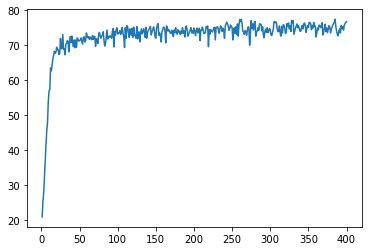

In [8]:
print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [9]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()
# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)